## Agent-Customer Conversation Topic Classification


In [1]:
import os
import io
import re
import numpy as np
import pandas as %pdoc
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import  preprocessing
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
import math

## Building model

In [ ]:
os.chdir('/content/drive/MyDrive/projects_assignment/idfy_nlp_assignment')
os.getcwd()

'/content/drive/MyDrive/projects_assignment/idfy_nlp_assignment'

Dictionary for expanding the contracted words

In [ ]:
CONTRACTION_MAP = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" 
                   }

### Data Cleaning
Different helper methods to clean and Prepare the data

In [ ]:
def clean_script(script_text):
  'This method takes the script_text:string as an input and returns the same after cleaning'

  # print(script_text)
  script_text = script_text.lower()

  #removes the token like '[silence]' or [']
  script_text = re.sub('[\[[a-z]*\-[a-z]*]|[\[[a-z]*]', ' ', script_text)

  #this removes all the extra whitespace
  script_text = re.sub('[\s]{2,}', ' ',script_text)

  #this removes the repeating 'yeah'. As this token is important so removing the repeating one
  #what is does that it replace the yeah yeah with yeah or yeah yeah yeah with yeah and so on
  script_text = re.sub('yeah\syeah|yeah\syeah\syeah|yeah\syeah\syeah\syeah|yeah\syeah\syeah\syeah\syeah', 'yeah', script_text)
  script_text = re.sub('[\s]{2,}', ' ',script_text)
  script_text = re.sub('yeah\syeah|yeah\syeah\syeah|yeah\syeah\syeah\syeah|yeah\syeah\syeah\syeah\syeah', 'yeah', script_text)

  #this removes the 'um', 'uh', 'um-hum', 'i-', '-i' or '-' from the script as alomst useless. As these are repeating alot and not adding much of value 
  script_text = re.sub('um|uh|]\s\w\-|\-\s|\-\w|\w\-', '',script_text)

  #removing tag like <b_aside> or <e_aside>
  script_text = re.sub('<.*?>' ,'', script_text)

  #this removes all the extra whitespace
  script_text = re.sub('[\s]{2,}', ' ',script_text)
  return ' '+script_text.strip()

def pre_process_conv_script(txt_file): 
  'This method takes the conversation script file_path as input and returns the cleaned string'

  #we'll get the file id from the text file name - will be used later to build the train and test dataset
  file_id_search = re.search('[0-9]+', txt_file)
  file_id = txt_file[file_id_search.start():file_id_search.end()]

  final_str = ''
  script_lines = io.open(txt_file,encoding='UTF-8').read().split('\n')
  for script in script_lines:
    script = ' '.join(script.split(' ')[3:])
   
    script = clean_script(script)
    
    final_str += script

  #just removes extra white spaces
  final_str = re.sub('[\s]{2,}', ' ',final_str)

  return final_str.strip(), file_id
    

In [ ]:
# Prepare Data 
# For classical ML approach like Bow / tfidf we'll have to prepare the data with expanded contractions eg. 'don't' to 'do not'
def expand_contraction(cleaned_script, key, value):
  'This method expands the contracted word. Takes words, key and value as an input'
  cleaned_script = re.sub(key, value, cleaned_script)
  return cleaned_script

# Modern state of the art algorithms like Bert do not care wether word is contracted or uncontracted. 

def prep_data():
  'This method prepares the data. returns the label_list and list of cleaned conversation script'
  #this list stores all the clean conv script
  clean_script_list = []
  clean_script_uncontracted = []
  label_list = []
  
  # Storing all text files in a list
  text_files = os.listdir('tagging_test')[:-1]
  contraction_keys  = list(CONTRACTION_MAP.keys())
  
  for text_file in text_files:
    # get the clean text for each text file
    clean_script, label_id = pre_process_conv_script('tagging_test/'+text_file)
    clean_script_list.append(clean_script)
    label_list.append(label_id)

    for key in contraction_keys:
      clean_script = expand_contraction(clean_script, key, CONTRACTION_MAP.get(key))
    clean_script_uncontracted.append(clean_script)

  return label_list, clean_script_list, clean_script_uncontracted


In [ ]:
label_list, clean_script_list, clean_script_uncontracted = prep_data()

### Building dataframe
We'll prepare data out of list returned by prep_data

In [ ]:
#prep pandas dataframe out of it
data_uncontracted = pd.DataFrame(data=list(zip(label_list, clean_script_uncontracted)), columns = ['label_id', 'conv_script'])
data_contracted  = pd.DataFrame(data=list(zip(label_list, clean_script_list)), columns = ['label_id', 'conv_script'])

In [ ]:
data_uncontracted.sample(10)

,label_id,conv_script
170,4615,why do not you go ahead first okay short term ...
165,4383,do you think should be done for the the huge b...
103,2478,colorado springs oh right up in ti out there y...
22,2092,well the thing is is that since i am in school...
106,2591,the whole savings and loan thing seems to be a...
46,2235,okay hi okay you wanna start hi yeah sure i th...
217,2791,okay official time well what do you think of a...
4,3077,americans like me and whether or not not i thi...
81,4240,so how do you like the benefits of ti well act...
147,2916,okay i do not think i have ever met anybody th...


In [ ]:
data_contracted.sample(10)

,label_id,conv_script
22,2092,well the thing is is that since i'm in school ...
216,2447,probably the lifestyles and the size of the ar...
21,2234,well my family moved to texas about eight year...
8,3312,kind of options do you have in your work as fa...
130,2782,i guess so okay ready to talk okay i want to t...
54,3084,okay i guess we're going to talk about budgets...
167,3786,o okay so you were with ti h yeah i've been wi...
117,2508,how do you manage your budget well let's see w...
95,2917,hi what do you do with your credit cards oh we...
39,2250,so what kind of benefits do you have in your j...


In [ ]:
os.getcwd()

'/content/drive/My Drive/projects_assignment/idfy_nlp_assignment'

### Preparing class labels
Since class labels for each conversation script is in different files so we'll have to process those all

In [ ]:
#now let's process the label text file and conact that with script dataFrame
def prep_label():
  'This methods prepares the lis of labels and label ids'
  all_labels_list = []
  all_labels_id = []

  path_to_file = 'tagging_test/metadata/mapping_conv_topic.train.txt'
  label_lines = io.open(path_to_file,encoding='UTF-8').read().split('\n')

  for label_line in label_lines:
    
    try:
      all_labels_id.append(label_line.split()[0])
      all_labels_list.append(re.sub('"', '', ' '.join(label_line.split()[1:])))
    #putting exception block as few problem with the text file in last line. So all good with exception
    except:
      continue
    
    
  return all_labels_list, all_labels_id


In [ ]:
all_labels_list, all_labels_id = prep_label()

Building dataframe for the class labels

In [ ]:
data_label  = pd.DataFrame(data=list(zip(all_labels_id, all_labels_list)), columns = ['label_id', 'class_label'])
data_label.sample(5)

,label_id,class_label
142,4254,Job Benefits
16,2800,Credit Card
102,2129,Job Benefits
49,2327,Taxes
208,4379,Family Finance


### Merging class labels and Conversation Scripts together

In [ ]:
#concatinatng Labels dataframe with the script
data_uncontracted = data_uncontracted.merge(data_label)
data_uncontracted

,label_id,conv_script,class_label
0,4160,so do you keep a family budget well not a real...,Family Finance
1,3196,hello hello hi boy it took forever to find som...,Credit Card
2,2424,there we go okay well what do you think about ...,Taxes
3,3270,well i do not know if there is gonna be a solu...,Budget
4,3077,americans like me and whether or not not i thi...,Taxes
...,...,...,...
235,3673,you keep a budget yes i do okay how do you wor...,Family Finance
236,4031,is all you need h i think just one is all you ...,Family Finance
237,4209,jeff what do you think are you paying to much ...,Taxes
238,4222,cathy i am in boston hi i am ralph cincinnati ...,Taxes


In [ ]:
#concatinatng Labels dataframe with the script
data_contracted = data_contracted.merge(data_label)
data_contracted

,label_id,conv_script,class_label
0,4160,so do you keep a family budget well not a real...,Family Finance
1,3196,hello hello hi boy it took forever to find som...,Credit Card
2,2424,there we go okay well what do you think about ...,Taxes
3,3270,well i don't know if there's gonna be a soluti...,Budget
4,3077,americans like me and whether or not not i thi...,Taxes
...,...,...,...
235,3673,you keep a budget yes i do okay how do you wor...,Family Finance
236,4031,is all you need h i think just one is all you ...,Family Finance
237,4209,jeff what do you think are you paying to much ...,Taxes
238,4222,cathy i'm in boston hi i'm ralph cincinnati hi...,Taxes


Dumping files to the local disk to reload in future

In [ ]:
import pickle

In [ ]:
# Save all the on the disk to avoid re computation 
#pickle.dump((data_contracted, data_uncontracted),open('clean_data_with_label.pkl','wb'))

# Loading 
data_contracted, data_uncontracted= pickle.load(open('clean_data_with_label.pkl', 'rb'))

### Basic Analysis on Data
We'll have a look at class distribution 

In [ ]:
# we'll do basic data Analysis

# Looking at class distribution
data_uncontracted.class_label.value_counts()


Family Finance    63
Taxes             54
Job Benefits      54
Credit Card       41
Budget            22
Bank Bailout       6
Name: class_label, dtype: int64

we can see Bank Bailout is minor class here with just 6 examples. We'll have to look at this label while building model. <br>

#### Let's visualize the class distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


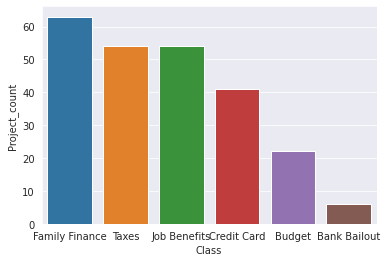

In [ ]:
class_plot = data_uncontracted.class_label.value_counts()
sns.set_style('darkgrid')
sns.barplot(class_plot.index, class_plot.values)
plt.xlabel("Class")
plt.ylabel("Project_count")
plt.show()

#### Doing analysis on conversation Script

In [ ]:
# like getting average size of conv script

uncontracted_lengths = data_uncontracted['conv_script'].str.split().apply(len)
contracted_lengths = data_contracted['conv_script'].str.split().apply(len)



print('*******Conv Script with contracted words ***********')

for i in range(0, 101,10):
  print(i, 'percentile', np.percentile(contracted_lengths, i))
print('\n')
for i in range(90, 102,2):
  print(i, 'percentile', np.percentile(contracted_lengths, i))
print('\n')
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
  print(i, 'percentile', np.percentile(contracted_lengths, i))

print('\n')


print('*******Conv Script with uncontracted words***********')

for i in range(0, 101,10):
  print(i, 'percentile', np.percentile(uncontracted_lengths, i))
print('\n')
for i in range(90, 102,2):
  print(i, 'percentile', np.percentile(uncontracted_lengths, i))
print('\n')
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
  print(i, 'percentile', np.percentile(uncontracted_lengths, i))

*******Conv Script with contracted words ***********
0 percentile 557.0
10 percentile 796.0
20 percentile 844.8000000000001
30 percentile 893.7
40 percentile 927.6
50 percentile 996.0
60 percentile 1063.6
70 percentile 1351.3999999999996
80 percentile 1621.0000000000007
90 percentile 1898.1
100 percentile 2249.0


90 percentile 1898.1
92 percentile 1923.52
94 percentile 2000.86
96 percentile 2074.2
98 percentile 2113.7200000000003
100 percentile 2249.0


99.1 percentile 2207.617999999999
99.2 percentile 2222.3759999999997
99.3 percentile 2228.8289999999997
99.4 percentile 2235.282000000001
99.5 percentile 2241.735
99.6 percentile 2247.088
99.7 percentile 2247.566
99.8 percentile 2248.044
99.9 percentile 2248.522
100 percentile 2249.0


*******Conv Script with uncontracted words***********
0 percentile 594.0
10 percentile 840.3
20 percentile 887.0
30 percentile 935.7
40 percentile 976.6
50 percentile 1042.5
60 percentile 1115.0
70 percentile 1422.3
80 percentile 1697.400000000001
90 per

As we can see above each converation script is fairy large.

### Prepare data for Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import  preprocessing
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
import math

#### Train, Test dataset

In [ ]:
#we'll have to split into train and test data
X_train, X_test, y_train, y_test = train_test_split(data_uncontracted['conv_script'], data_uncontracted['class_label'], test_size=0.30, stratify=data_uncontracted['class_label'])
print(X_train.shape, X_test.shape)

(168,) (72,)


In [ ]:
y_train.value_counts()

Family Finance    44
Taxes             38
Job Benefits      38
Credit Card       29
Budget            15
Bank Bailout       4
Name: class_label, dtype: int64

In [ ]:
y_test.value_counts()

Family Finance    19
Taxes             16
Job Benefits      16
Credit Card       12
Budget             7
Bank Bailout       2
Name: class_label, dtype: int64

#### Converting text to vector representation

In [ ]:
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
print(stopwords.words('english'))

In [ ]:
stopwords_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
                  'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
                  'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
                  'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 
                  'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 
                  'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
                  'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 
                  'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 
                  've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 
                  'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
                  "weren't", 'won', "won't", 'wouldn', "wouldn't"]

Initializing  count vectorizer

In [ ]:
# BoW vector representaion for the Conv Script
del uncontracted_vectorizer
uncontracted_vectorizer = CountVectorizer(stop_words=stopwords_list, max_features= 60000)
uncontracted_vectorizer.fit(X_train.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=60000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Converting text to Numeric vector with vectorizer

In [ ]:
X_train_bow = uncontracted_vectorizer.transform(X_train.values)
X_test_bow = uncontracted_vectorizer.transform(X_test.values)

#### Converting class labels to numerical representation

In [ ]:
# Also convert classes into categories
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

In [ ]:
label_encoder.classes_

array(['Bank Bailout', 'Budget', 'Credit Card', 'Family Finance',
       'Job Benefits', 'Taxes'], dtype=object)

In [ ]:
train_y = label_encoder.transform(y_train.values)
test_y = label_encoder.transform(y_test.values)

In [ ]:
train_y.shape

(168,)

### Model
#### Hyperparameter tunning the Niave Bayse

In [ ]:
#this model with 6193 vocab size

#CV
alpha_cv = []     #stores log(alpha) for plotting
auc_cv = []    #stores auc value Test

alpha_ = []  #stores alpha vaslue

alpha_tr = []     #stores log(alpha) for plotting 
auc_tr = []       #stores AUC Score on Train

i = 0.00001 #alpha value starting range

while i<=1000:   
    NB = MultinomialNB(alpha = i)
    ovr_NB = OneVsRestClassifier(NB)    
    ovr_NB.fit(X_train_bow, train_y)
    
    #Train Data
    predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
    # print(predicted.shape)
    auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
    auc_tr.append(auc)
    alpha_tr.append(math.log(i))
    
    # #Cv Data
    predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
    # print(predicted_.shape)
    auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
    auc_cv.append(auc_)
    alpha_cv.append(math.log(i))
    
    
    alpha_.append(i)
    
    i *= 10
    
    
#printing the alpha and corresponding AUC value
print("AUC Score on CV:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_cv[x]))

print("\nAUC Score on Train:")
for x in range(0, len(alpha_)):
    print("Alpha: {}, AUC: {}".format(alpha_[x], auc_tr[x]))

AUC Score on CV:
Alpha: 1e-05, AUC: 0.8809021718367237
Alpha: 0.0001, AUC: 0.8896736365486365
Alpha: 0.001, AUC: 0.9219813606532358
Alpha: 0.01, AUC: 0.9725773936711436
Alpha: 0.1, AUC: 0.9875713840557592
Alpha: 1.0, AUC: 0.9742715328652829
Alpha: 10.0, AUC: 0.953750445156695
Alpha: 100.0, AUC: 0.9452984989409704
Alpha: 1000.0, AUC: 0.9449242389279319

AUC Score on Train:
Alpha: 1e-05, AUC: 1.0
Alpha: 0.0001, AUC: 1.0
Alpha: 0.001, AUC: 1.0
Alpha: 0.01, AUC: 1.0
Alpha: 0.1, AUC: 1.0
Alpha: 1.0, AUC: 1.0
Alpha: 10.0, AUC: 0.9977001984378067
Alpha: 100.0, AUC: 0.9887389878235773
Alpha: 1000.0, AUC: 0.9821700417274698


In [ ]:
predicted_[0:1, :].shape

(1, 6)

#### Plotting AUC vs Alpha value

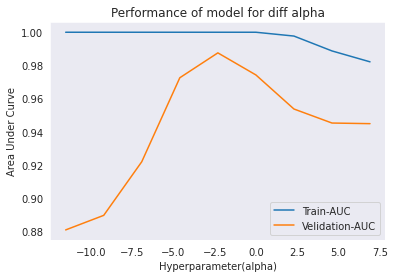

In [ ]:
plt.plot(alpha_tr, auc_tr, label="Train-AUC")
plt.plot(alpha_cv, auc_cv, label="Velidation-AUC")
plt.xlabel("Hyperparameter(alpha)")
plt.ylabel("Area Under Curve"); plt.title("Performance of model for diff alpha")
plt.legend()
plt.grid()
plt.show()

The optimal value for alpha = 0.1 for that we have max AUC score

In [ ]:
# train final model with optimal alpha = 0.1
NB = MultinomialNB(alpha = 0.1)
ovr_NB = OneVsRestClassifier(NB)    
ovr_NB.fit(X_train_bow, train_y)

#Train Data
predicted = ovr_NB.predict_proba(X_train_bow)   #returns probablity score
# print(predicted.shape)
auc = metrics.roc_auc_score(train_y, predicted[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on train : ', auc)

# #Cv Data
predicted_ = ovr_NB.predict_proba(X_test_bow)   #returns probablity score
# print(predicted_.shape)
auc_ = metrics.roc_auc_score(test_y, predicted_[:, :], multi_class='ovr')
print('AUC with alpha = 0.1 on test : ', auc_)

AUC with alpha = 0.1 on train :  1.0
AUC with alpha = 0.1 on test :  0.9875713840557592


In [ ]:
y_test.value_counts()

Family Finance    19
Taxes             16
Job Benefits      16
Credit Card       12
Budget             7
Bank Bailout       2
Name: class_label, dtype: int64

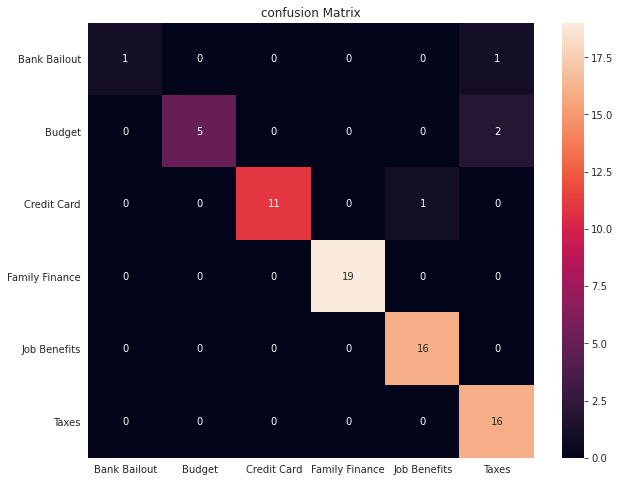

In [ ]:
#confusion maetrics too see what happening
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
predict = ovr_NB.predict(X_test_bow)
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

So here we can see, this model is fairly good at minor class compare to others. AUC score is highest here.

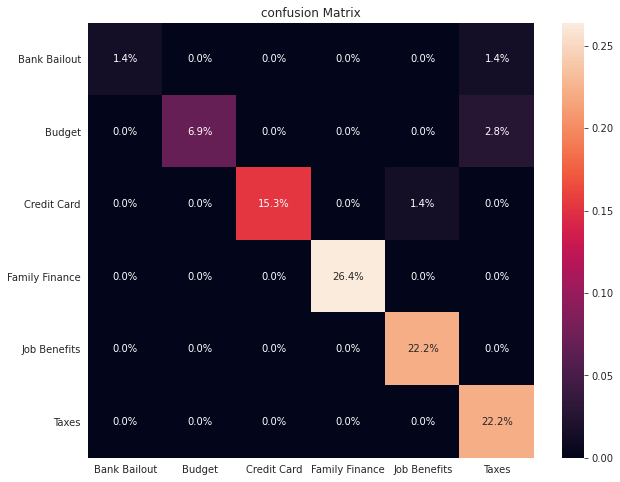

In [ ]:
cm = metrics.confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.01%', xticklabels=target_label, yticklabels=target_label)
plt.title('confusion Matrix')
plt.show()

In [ ]:
#save this model on disk
pickle.dump((ovr_NB),open('nb_over_optimal_2.pkl','wb'))

# to reload the model
#ovr_NB = pickle.load(open("nb_over_optimal.pkl", 'rb'))

#saving vectorizer
pickle.dump((uncontracted_vectorizer),open('nb_uncontracted_vectorizer_2.pkl','wb'))

#saving label encoder
pickle.dump((label_encoder),open('nb_uncontracted_label_encoder_2.pkl','wb'))

## Testing 

In [3]:
os.chdir('/content/drive/MyDrive/projects_assignment/idfy_nlp_assignment')
os.getcwd()

'/content/drive/MyDrive/projects_assignment/idfy_nlp_assignment'

### Loading the model and other files from the disk

In [4]:
#oad the model
#save this model on disk
# pickle.dump((ovr_NB),open('nb_over_optimal_2.pkl','wb'))

# to reload the model
ovr_NB = pickle.load(open("nb_over_optimal_2.pkl", 'rb'))

#saving vectorizer
#pickle.dump((uncontracted_vectorizer),open('nb_uncontracted_vectorizer_2.pkl','wb'))
uncontracted_vectorizer = pickle.load(open("nb_uncontracted_vectorizer_2.pkl", 'rb'))

#saving label encoder
#pickle.dump((label_encoder),open('nb_uncontracted_label_encoder_2.pkl','wb'))
label_encoder = pickle.load(open("nb_uncontracted_label_encoder_2.pkl", 'rb'))

### Data cleaning forca Query Script File

In [11]:
CONTRACTION_MAP = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" 
                   }

In [23]:
def clean_script(script_text):
  '''Takes each script line as an input. And returns the same after cleaning'''
  script_text = script_text.lower()

  #removes the token like '[silence]' or [']
  script_text = re.sub('[\[[a-z]*\-[a-z]*]|[\[[a-z]*]', ' ', script_text)

  #this removes all the extra whitespace
  script_text = re.sub('[\s]{2,}', ' ',script_text)

  #this removes the repeating 'yeah'. As this token is important so removing the repeating one
  #what is does that it replace the yeah yeah with yeah or yeah yeah yeah with yeah and so on
  script_text = re.sub('yeah\syeah|yeah\syeah\syeah|yeah\syeah\syeah\syeah|yeah\syeah\syeah\syeah\syeah', 'yeah', script_text)
  script_text = re.sub('[\s]{2,}', ' ',script_text)
  script_text = re.sub('yeah\syeah|yeah\syeah\syeah|yeah\syeah\syeah\syeah|yeah\syeah\syeah\syeah\syeah', 'yeah', script_text)

  #this removes the 'um', 'uh', 'um-hum', 'i-', '-i' or '-' from the script as alomst useless. As these are repeating alot and not adding much of value 
  script_text = re.sub('um|uh|]\s\w\-|\-\s|\-\w|\w\-', '',script_text)

  #removing tag like <b_aside> or <e_aside>
  script_text = re.sub('<.*?>' ,'', script_text)

  #this removes all the extra whitespace
  script_text = re.sub('[\s]{2,}', ' ',script_text)
  return ' '+script_text.strip()

def pre_process_conv_script(txt_file):
  'This method takes text file and returns a string'

  final_str = ''
  script_lines = io.open(txt_file,encoding='UTF-8').read().split('\n')
  for script in script_lines:
    script = ' '.join(script.split(' ')[3:])
   
    script = clean_script(script)
    
    final_str += script

  #just removes extra white spaces
  final_str = re.sub('[\s]{2,}', ' ',final_str)

  return final_str.strip()


# For classical ML approach like Bow / tfidf we'll have to prepare the data with expanded contractions eg. 'don't' to 'do not'
def expand_contraction(cleaned_script, key, value):
  cleaned_script = re.sub(key, value, cleaned_script)
  return cleaned_script

# Modern state of the art algorithms like Bert do not care wether word is contracted or uncontracted. 

def prepare_data(text_file):
  'This method is called to clean up the input script .txt file and returns the string'
  
  contraction_keys  = list(CONTRACTION_MAP.keys())
  
  clean_script = pre_process_conv_script(text_file)

  for key in contraction_keys:
    clean_script = expand_contraction(clean_script, key, CONTRACTION_MAP.get(key))

  return [clean_script]


### Predictor Method

In [46]:
def predict_topic(text_file, predictor, uncontracted_vectorizer, label_encoder):
  'This method takes the query tex_file, model, vectorizer and label_encoder as an iput and gives the predicted class label'
  
  #cleanup the text
  clean_com_script = prepare_data(text_file)

  #get the bow vector representation
  script_vector = uncontracted_vectorizer.transform(clean_com_script)

  #do the prediction from the model
  class_prob = predictor.predict_proba(script_vector)

  #get the classesfrom label_encoder.classes_
  predicted_class_label = label_encoder.classes_[class_prob[0].argmax()]

  print('Topic for given Conv Script: ', predicted_class_label)

In [50]:
predict_topic('tagging_test/trans.2228.txt', ovr_NB, uncontracted_vectorizer, label_encoder)

Topic for given Conv Script:  Bank Bailout
